# Imports

In [1]:
import pandas as pd
import pprint as pp
import matplotlib.pyplot as plt
import plotly.express as px
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
import time
import os
from tqdm import tqdm



# Load Data

Dataset containing information about each company on the INC 5000 list in 2019. Fields include the company name, industry, founding year, website, and location, as well as 2019 revenue, % growth, number of workers (year-over-year), and the number of years on the list.

In [2]:
INPUT_FILE_PATH = "data/INC 5000 Companies 2019.csv"

In [3]:
raw_df = pd.read_csv(INPUT_FILE_PATH) 
print(f"shape of DataFrame : {raw_df.shape}")
raw_df.head()

shape of DataFrame : (5012, 14)


,rank,profile,name,url,state,revenue,growth_%,industry,workers,previous_workers,founded,yrs_on_list,metro,city
0,1,https://www.inc.com/profile/freestar,Freestar,http://freestar.com,AZ,36.9 Million,36680.3882,Advertising & Marketing,40.0,5,2015,1,Phoenix,Phoenix
1,2,https://www.inc.com/profile/freightwise,FreightWise,http://freightwisellc.com,TN,33.6 Million,30547.9317,Logistics & Transportation,39.0,8,2015,1,Nashville,Brentwood
2,3,https://www.inc.com/profile/ceces-veggie,Cece's Veggie Co.,http://cecesveggieco.com,TX,24.9 Million,23880.4852,Food & Beverage,190.0,10,2015,1,Austin,Austin
3,4,https://www.inc.com/profile/ladyboss,LadyBoss,http://ladyboss.com,NM,32.4 Million,21849.8925,Consumer Products & Services,57.0,2,2014,1,NaN,Albuquerque
4,5,https://www.inc.com/profile/perpay,Perpay,http://perpay.com,PA,22.5 Million,18166.4070,Retail,25.0,6,2014,1,Philadelphia,Philadelphia


## Attirbute datatypes 

In [4]:
print(raw_df.dtypes)

rank                  int64
profile              object
name                 object
url                  object
state                object
revenue              object
growth_%            float64
industry             object
workers             float64
previous_workers      int64
founded               int64
yrs_on_list           int64
metro                object
city                 object
dtype: object


# Preprocessing

## Dealing with Null values

In [5]:
print(raw_df.isna().sum())

rank                  0
profile               0
name                  0
url                   0
state                 0
revenue               0
growth_%              0
industry              0
workers               1
previous_workers      0
founded               0
yrs_on_list           0
metro               813
city                  0
dtype: int64


### column: metro
Metropolitan area the city is located in 
* Eg. Long Beach in Los Angeles

In [6]:
print(f"No. of cities with Null metro: {len(raw_df[raw_df['metro'].isna()]['city'].unique())}")

No. of cities with Null metro: 483


In [7]:
# we fill null metropolitan area with city
raw_df['metro'] = raw_df['metro'].fillna(raw_df['city'])
raw_df['metro'].isna().sum()

0

### column: workers

In [8]:
raw_df[raw_df['workers'].isna()]

,rank,profile,name,url,state,revenue,growth_%,industry,workers,previous_workers,founded,yrs_on_list,metro,city
3755,3746,https://www.inc.com/profile/mansari,Mansari,https://www.collegehunkshaulingjunk.com/tampa-...,FL,2.5 Million,90.7485,Consumer Products & Services,NaN,20,2008,1,Tampa,Tampa


In [9]:
raw_df = raw_df.dropna(subset=['workers'])
print(f"shape of DataFrame after dropping: {raw_df.shape}")
print(f"No. of rows with Null values in workers after dropping: {raw_df['workers'].isna().sum()}")

shape of DataFrame after dropping: (5011, 14)
No. of rows with Null values in workers after dropping: 0


## Geocoding

### Geocode function

In [10]:
import os
import time
import requests
import pandas as pd
from tqdm import tqdm

NOMINATIM_URL = "https://nominatim.openstreetmap.org/search"
HEADERS = {"User-Agent": "geoapi-mayank"}

def get_lat_lon_for_cities(city_state_df, cache_file, sleep_time=1.1):
    """
    Geocode unique city-state pairs and cache results.

    Parameters:
    - city_state_df (pd.DataFrame): DataFrame with 'city' and 'state' columns (unique pairs).
    - cache_file (str): Path to save/load cached results.
    - sleep_time (float): Time to sleep between requests to avoid rate-limiting.

    Returns:
    - pd.DataFrame: city_state_df with added 'latitude' and 'longitude' columns.
    """

    def geocode(row, retries=3, backoff=2):
        query = f"{row['city']}, {row['state']}, USA"
        params = {"q": query, "format": "json", "limit": 1}

        for attempt in range(retries):
            try:
                response = requests.get(NOMINATIM_URL, headers=HEADERS, params=params, timeout=10)
                if response.status_code == 200:
                    data = response.json()
                    if data:
                        return float(data[0]['lat']), float(data[0]['lon'])
                else:
                    print(f"Error {response.status_code} for {query}")
            except requests.RequestException as e:
                print(f"Request failed for {query} (attempt {attempt + 1}): {e}")
                time.sleep(backoff ** attempt)

        return None, None

    if os.path.exists(cache_file):
        print(f"Loading from cache: {cache_file}")
        cached_df = pd.read_csv(cache_file)
    else:
        city_state_df = city_state_df.drop_duplicates().reset_index(drop=True)
        print(f"Geocoding {len(city_state_df)} unique city-state pairs...")

        latitudes, longitudes = [], []
        for _, row in tqdm(city_state_df.iterrows(), total=len(city_state_df), desc="Geocoding"):
            lat, lon = geocode(row)
            latitudes.append(lat)
            longitudes.append(lon)
            time.sleep(sleep_time)

        city_state_df["latitude"] = latitudes
        city_state_df["longitude"] = longitudes
        cached_df = city_state_df
        cached_df.to_csv(cache_file, index=False)

    return cached_df


def geocode_cities(raw_df, cache_file):
    """
    Merge latitude and longitude into raw_df using city-state pairs.

    Parameters:
    - raw_df (pd.DataFrame): Full DataFrame with 'city' and 'state' columns.
    - cache_file (str): Path to cached city-state geocoded data.

    Returns:
    - pd.DataFrame: raw_df with 'latitude' and 'longitude' columns merged.
    """
    city_state_df = raw_df[['city', 'state']].copy()
    geo_df = get_lat_lon_for_cities(city_state_df, cache_file)
    print(geo_df.isna().sum())
    return raw_df.merge(geo_df, on=['city', 'state'], how='left')


In [12]:
geocoded_df = geocode_cities(raw_df,"data/lat-lon-cache.csv")

Loading from cache: data/lat-lon-cache.csv
city          0
state         0
latitude     21
longitude    21
dtype: int64


### null values

In [13]:
geocoded_df.isna().sum()

rank                 0
profile              0
name                 0
url                  0
state                0
revenue              0
growth_%             0
industry             0
workers              0
previous_workers     0
founded              0
yrs_on_list          0
metro                0
city                 0
latitude            31
longitude           31
dtype: int64

In [14]:
print(f"Number of cities with Null geocode: {len(geocoded_df[geocoded_df.isnull().any(axis=1)][['city','state']].drop_duplicates())}")
print(geocoded_df[geocoded_df.isnull().any(axis=1)][['city','state']].drop_duplicates())

Number of cities with Null geocode: 21
                 city state
286        Birmimgham    AL
309       Solana Bech    CA
454     Please Select    LA
457        Schaumberg    IL
790         Covingtom    LA
824            Chicao    IL
1174  Colorad Springs    CO
1203        Arlignton    TX
1209       Greenville    SD
1399       Swannnanoa    NC
1594             Wash    DC
1653    Saint Charles    IL
1776      Minneapolis    PA
2174             wall    NJ
3524      Cincinnnati    OH
3717      Naperrville    IL
4044     COTTONWD HTS    UT
4169        Kasyville    UT
4497          Ahaheim    CA
4507             Wall    NJ
4985       Encinitass    CA


### Issues in data

* Some are spelling mistakes in city names
* Wrong state for Minneapolis -> Nelson
    * given PA
    * actual MN
* Wrong state for Greenville -> Lima One Capital 
    * given SD
    * actual SC 

In [ ]:
city_corrections = pd.DataFrame({
    "city": [
        "Birmimgham", "Solana Bech", "Please Select", "Schaumberg", "Covingtom",
        "Chicao", "Colorad Springs", "Arlignton", "Greenville", "Swannnanoa",
        "Wash", "Saint Charles", "Minneapolis", "wall", "Cincinnnati",
        "Naperrville", "COTTONWD HTS", "Kasyville", "Ahaheim", "Wall", "Encinitass"
    ],
    "state": [
        "AL", "CA", "LA", "IL", "LA", "IL", "CO", "TX", "SD", "NC", "DC", "IL", "PA",
        "NJ", "OH", "IL", "UT", "UT", "CA", "NJ", "CA"
    ],
    "corrected_city": [
        "Birmingham", "Solana Beach", "Houma", "Schaumburg", "Covington", "Chicago",
        "Colorado Springs", "Arlington", "Greenville", "Swannanoa", "Washington",
        "St. Charles", "Minneapolis", "Wall Township", "Cincinnati", "Naperville",
        "Cottonwood Heights", "Kaysville", "Anaheim", "Wall Township", "Encinitas"
    ]
})

city_corrections["corrected_state"] = city_corrections["state"]

# Fix wrong states
city_corrections.loc[city_corrections["city"] == "Minneapolis", "corrected_state"] = "MN"
city_corrections.loc[city_corrections["city"] == "Greenville", "corrected_state"] = "SC"

city_corrections


,city,state,corrected_city,corrected_state
0,Birmimgham,AL,Birmingham,AL
1,Solana Bech,CA,Solana Beach,CA
2,Please Select,LA,Houma,LA
3,Schaumberg,IL,Schaumburg,IL
4,Covingtom,LA,Covington,LA
5,Chicao,IL,Chicago,IL
6,Colorad Springs,CO,Colorado Springs,CO
7,Arlignton,TX,Arlington,TX
8,Greenville,SD,Greenville,SC
9,Swannnanoa,NC,Swannanoa,NC


### correcting latitude and longitude

In [42]:
missing_city_state = pd.DataFrame(
    city_corrections[['corrected_state','corrected_city']],
)
missing_city_state.columns = ['state','city']
missing_city_state.drop_duplicates()
print(len(missing_city_state))
missing_city_state

21


,state,city
0,AL,Birmingham
1,CA,Solana Beach
2,LA,Houma
3,IL,Schaumburg
4,LA,Covington
5,IL,Chicago
6,CO,Colorado Springs
7,TX,Arlington
8,SC,Greenville
9,NC,Swannanoa


In [43]:
missing_lat_lon_df = get_lat_lon_for_cities(
    missing_city_state,
    "data/missing-cache.csv"
)

Geocoding 20 unique city-state pairs...


Geocoding: 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


In [47]:
missing_lat_lon_df.columns = ['corrected_state','corrected_city','corrected_latitude','corrected_longitude']
missing_lat_lon_df = missing_lat_lon_df.merge(
    city_corrections,
    on=['corrected_state','corrected_city'],
    how = "left"
)
missing_lat_lon_df

,corrected_state,corrected_city,corrected_latitude,corrected_longitude,city,state
0,AL,Birmingham,33.520682,-86.802433,Birmimgham,AL
1,CA,Solana Beach,32.990560,-117.269131,Solana Bech,CA
2,LA,Houma,29.595770,-90.719535,Please Select,LA
3,IL,Schaumburg,42.033361,-88.083406,Schaumberg,IL
4,LA,Covington,30.475352,-90.101047,Covingtom,LA
5,IL,Chicago,41.875562,-87.624421,Chicao,IL
6,CO,Colorado Springs,38.833958,-104.825348,Colorad Springs,CO
7,TX,Arlington,32.735582,-97.107119,Arlignton,TX
8,SC,Greenville,34.851354,-82.398488,Greenville,SD
9,NC,Swannanoa,35.599829,-82.403393,Swannnanoa,NC


### merging in geocoded_df

In [48]:
# Merge with correction table
geocoded_df = geocoded_df.merge(missing_lat_lon_df, on=["city", "state"], how="left")

# Update city and state only if a correction is available
geocoded_df["city"] = geocoded_df["corrected_city"].combine_first(geocoded_df["city"])
geocoded_df["state"] = geocoded_df["corrected_state"].combine_first(geocoded_df["state"])

# Update latitude and longitude where corrections are present
geocoded_df["latitude"] = geocoded_df["corrected_latitude"].combine_first(geocoded_df["latitude"])
geocoded_df["longitude"] = geocoded_df["corrected_longitude"].combine_first(geocoded_df["longitude"])

# Drop the temporary correction columns
geocoded_df.drop(columns=[
    "corrected_city", "corrected_state", "corrected_latitude", "corrected_longitude"
], inplace=True)


In [49]:
geocoded_df.isna().sum()

rank                0
profile             0
name                0
url                 0
state               0
revenue             0
growth_%            0
industry            0
workers             0
previous_workers    0
founded             0
yrs_on_list         0
metro               0
city                0
latitude            0
longitude           0
dtype: int64

# EDA

In [10]:
raw_df.describe()

,rank,growth_%,workers,previous_workers,founded,yrs_on_list
count,5011.000000,5011.000000,5011.000000,5011.000000,5011.000000,5011.000000
mean,2499.379565,454.752685,242.783077,111.705448,2005.445021,2.814009
std,1443.268601,1284.406582,2800.165478,1073.984562,30.313635,2.266067
min,1.000000,52.169100,0.000000,1.000000,0.000000,1.000000
25%,1249.500000,90.559000,22.000000,8.000000,2003.000000,1.000000
50%,2497.000000,157.542700,48.000000,20.000000,2009.000000,2.000000
75%,3749.500000,330.548700,116.000000,50.000000,2012.000000,4.000000
max,5000.000000,36680.388200,155000.000000,53000.000000,2016.000000,14.000000


## Industry

In [30]:
print(f"No. of unique industries: {len(raw_df['industry'].unique())}")

No. of unique industries: 27


In [31]:
# Top industries by count
industry_counts = raw_df['industry'].value_counts().reset_index()
industry_counts.columns = ['industry', 'count']
industry_counts.head()

,industry,count
0,Business Products & Services,492
1,Advertising & Marketing,489
2,Software,461
3,Health,356
4,Construction,350


# Spatial EDA

Columns of interest
* state
* city

## Number of companies per state

In [ ]:
state_counts = raw_df['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']
# top 5 states by No. of companies
state_counts.head()

,state,count
0,CA,712
1,TX,467
2,FL,384
3,NY,300
4,VA,288


### Bar plot

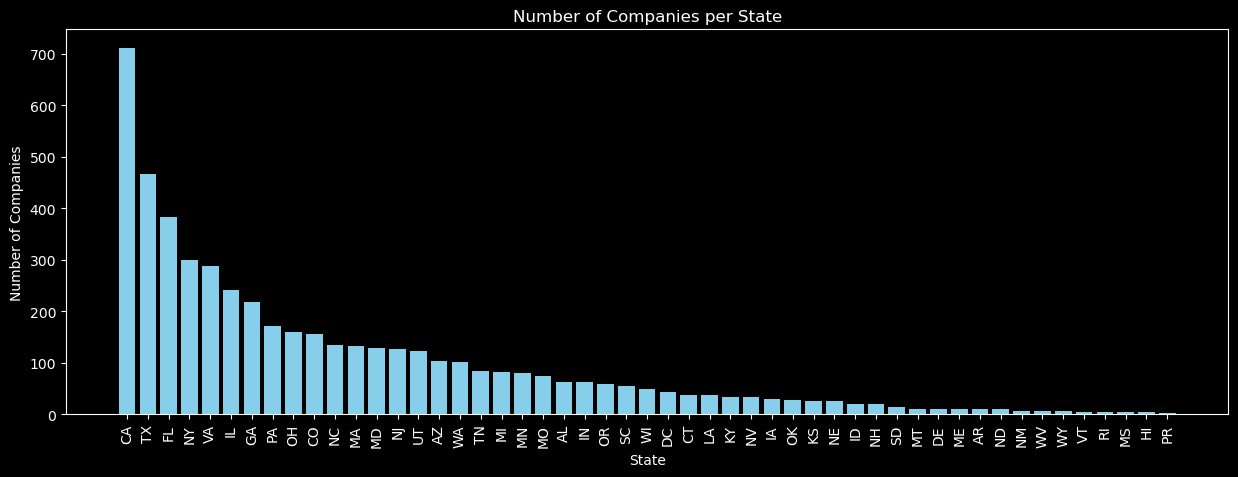

In [23]:
plt.figure(figsize=(15, 5))
plt.style.use('dark_background')
plt.bar(state_counts['state'], state_counts['count'], color='skyblue')
plt.xlabel('State')
plt.ylabel('Number of Companies')
plt.title('Number of Companies per State')
plt.xticks(rotation=90)
plt.show()

## Choropleth map

In [ ]:
fig = px.choropleth(
    state_counts,
    locations='state',
    locationmode='USA-states',
    color='count',
    color_continuous_scale='Viridis',
    scope='usa',
    title='Number of Companies per State'
)
fig.update_layout(template='plotly_dark')
fig.show()